<a href="https://colab.research.google.com/github/youngchul-sung/three-minutes-keras/blob/master/ex9_2_pretarined_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

"""
CH 9.1 Applications/Image Augmentation
"""
from sklearn import model_selection
from tensorflow import keras
from tensorflow.keras import datasets

TensorFlow 2.x selected.


In [0]:
"""
skeras.py
"""

import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib

def save_history_history(fname, history_history, fold=''):
    np.save(os.path.join(fold, fname), history_history)


def load_history_history(fname, fold=''):
    history_history = np.load(os.path.join(fold, fname)).item(0)
    return history_history


def plot_acc(history, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_acc(history)
    plt.subplot(1, 2, 2)
    plot_loss(history)

    
def plot_loss_acc(history):
    plot_loss(history, '(a) Loss trajectory')
    plt.show()            
    plot_acc(history, '(b) Accracy trajectory')
    plt.show()
    
    
def plot_acc_loss(history):
    plot_acc(history, '(a) Accracy trajectory')
    plt.show()
    plot_loss(history, '(b) Loss trajectory')
    plt.show()


In [0]:
"""
sfile.py
"""

import datetime
import uuid
import os


def unique_filename(type='uuid'):
    if type == 'datetime':
        filename = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
    else:  # type == "uuid"
        filename = str(uuid.uuid4())
    return filename


def makenewfold(prefix='output_', type='datetime'):
    suffix = unique_filename('datetime')
    foldname = 'output_' + suffix
    os.makedirs(foldname)
    return foldname

In [0]:
"""
aicnn.py 

CNN for image classification
- MIT License
- Author: Sungjin Kim
"""
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout



class aicnn_CNN(Model):
    def __init__(model, nb_classes, in_shape=None):
        super().__init__()
        model.nb_classes = nb_classes
        model.in_shape = in_shape
        model.build_model()
        super().__init__(model.x, model.y)
        model.compile()

    def build_model(model):
        nb_classes = model.nb_classes
        in_shape = model.in_shape

        x = Input(in_shape)

        h = Conv2D(32, kernel_size=(3, 3), activation='relu',
                   input_shape=in_shape)(x)
        h = Conv2D(64, (3, 3), activation='relu')(h)
        h = MaxPooling2D(pool_size=(2, 2))(h)
        h = Dropout(0.25)(h)
        h = Flatten()(h)
        z_cl = h

        h = Dense(128, activation='relu')(h)
        h = Dropout(0.5)(h)
        z_fl = h

        y = Dense(nb_classes, activation='softmax', name='preds')(h)

        model.cl_part = Model(x, z_cl)
        model.fl_part = Model(x, z_fl)

        model.x, model.y = x, y

    def compile(model):
        Model.compile(model, loss='categorical_crossentropy',
                      optimizer=optimizers.Adadelta(learning_rate=1.0), metrics=['accuracy'])


class aicnn_DataSet:
    def __init__(self, X, y, nb_classes, scaling=True, test_size=0.2, random_state=0):
        """
        X is originally vector. Hence, it will be transformed
        to 2D images with a channel (i.e, 3D).
        """
        self.X = X
        self.add_channels()

        X = self.X
        # the data, shuffled and split between train and test sets
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.2, random_state=random_state)

        print(X_train.shape, y_train.shape)

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        if scaling:
            # scaling to have (0, 1) for each feature (each pixel)
            scaler = MinMaxScaler()
            n = X_train.shape[0]
            X_train = scaler.fit_transform(
                X_train.reshape(n, -1)).reshape(X_train.shape)
            n = X_test.shape[0]
            X_test = scaler.transform(
                X_test.reshape(n, -1)).reshape(X_test.shape)
            self.scaler = scaler

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_test.shape[0], 'test samples')

        # convert class vectors to binary class matrices
        Y_train = keras.utils.to_categorical(y_train, nb_classes)
        Y_test = keras.utils.to_categorical(y_test, nb_classes)

        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.y_train, self.y_test = y_train, y_test
        # self.input_shape = input_shape

    def add_channels(self):
        X = self.X

        if len(X.shape) == 3:
            N, img_rows, img_cols = X.shape

            if K.image_data_format() == 'th':
                X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                input_shape = (1, img_rows, img_cols)
            else:
                X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                input_shape = (img_rows, img_cols, 1)
        else:
            input_shape = X.shape[1:]  # channel is already included.

        self.X = X
        self.input_shape = input_shape


class aicnn_Machine():
    def __init__(self, X, y, nb_classes=2, fig=True):
        self.nb_classes = nb_classes
        self.set_data(X, y)
        self.set_model()
        self.fig = fig

    def set_data(self, X, y):
        nb_classes = self.nb_classes
        self.data = aicnn_DataSet(X, y, nb_classes)
        print('data.input_shape', self.data.input_shape)

    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = aicnn_CNN(nb_classes=nb_classes, in_shape=data.input_shape)
        # cnn_lenet(nb_classes=nb_classes, in_shape=data.input_shape)

    def fit(self, epochs=10, batch_size=128, verbose=1):
        data = self.data
        model = self.model

        history = model.fit(data.X_train, data.Y_train, batch_size=batch_size, epochs=epochs,
                            verbose=verbose, validation_data=(data.X_test, data.Y_test))
        return history

    def run(self, epochs=100, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        fig = self.fig

        history = self.fit(epochs=epochs,
                           batch_size=batch_size, verbose=verbose)

        score = model.evaluate(data.X_test, data.Y_test, verbose=0)

        print('Confusion matrix')
        Y_test_pred = model.predict(data.X_test, verbose=0)
        y_test_pred = np.argmax(Y_test_pred, axis=1)
        print(metrics.confusion_matrix(data.y_test, y_test_pred))

        print('Test score:', score[0])
        print('Test accuracy:', score[1])

        # Save results
        suffix = unique_filename('datatime')
        foldname = 'output_' + suffix
        os.makedirs(foldname)
        save_history_history(
            'history_history.npy', history.history, fold=foldname)
        model.save_weights(os.path.join(foldname, 'dl_model.h5'))
        print('Output results are saved in', foldname)
          
        if fig:
            plot_acc_loss(history)

        self.history = history

        return foldname

In [0]:
"""
aigen.py

Generator code for the image data augmentation
- MIT Licence
- Author: Sungjin Kim
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class aigen_Machine_Generator(aicnn_Machine):
    def __init__(self, X, y, nb_classes=2, steps_per_epoch=5, fig=True,
                 gen_param_dict=None):
        super().__init__(X, y, nb_classes=nb_classes, fig=fig)
        self.set_generator(steps_per_epoch=steps_per_epoch,
                           gen_param_dict=gen_param_dict)

    def set_generator(self, steps_per_epoch=10, gen_param_dict=None):
        if gen_param_dict is not None:
            self.generator = ImageDataGenerator(**gen_param_dict)
        else:
            self.generator = ImageDataGenerator()

        print(self.data.X_train.shape)

        self.generator.fit(self.data.X_train, seed=0)
        self.steps_per_epoch = steps_per_epoch

    def fit(self, epochs=10, batch_size=64, verbose=1):
        model = self.model
        data = self.data
        generator = self.generator
        steps_per_epoch = self.steps_per_epoch

        history = model.fit_generator(
            generator.flow(data.X_train, data.Y_train, batch_size=batch_size),
            epochs=epochs, steps_per_epoch=steps_per_epoch,
            validation_data=(data.X_test, data.Y_test))

        return history

In [0]:
"""
aiprt.py

Pretrained methods
- MIT Licence
- Sungjin Kim
"""
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import VGG16


class aiprt_CNN(aicnn_CNN):
    def __init__(model, input_shape, nb_classes,
                 n_dense=128, p_dropout=0.5, BN_flag=False,
                 PretrainedModel=VGG16):
        """
        If BN_flag is True, BN is used instaed of Dropout
        """
        model.in_shape = input_shape
        model.n_dense = n_dense
        model.p_dropout = p_dropout
        model.PretrainedModel = PretrainedModel
        model.BN_flag = BN_flag
        super().__init__(nb_classes)

    def build_model(model):
        nb_classes = model.nb_classes
        input_shape = model.in_shape
        PretrainedModel = model.PretrainedModel
        # print(nb_classes)

        # base_model = VGG16(weights='imagenet', include_top=False)

        base_model = PretrainedModel(
            weights='imagenet',
            include_top=False, input_shape=input_shape)

        x = base_model.input
        h = base_model.output
        z_cl = h  # Saving for cl output monitoring.

        h = model.topmodel(h)

        z_fl = h  # Saving for fl output monitoring.

        y = Dense(nb_classes, activation='softmax', name='preds')(h)
        # y = Dense(4, activation='softmax')(h)

        for layer in base_model.layers:
            layer.trainable = False

        model.cl_part = Model(x, z_cl)
        model.fl_part = Model(x, z_fl)

        model.x = x
        model.y = y

    def topmodel(model, h):
        '''
        Define topmodel
        if BN_Flag is True, BN is used instead of Dropout
        '''
        BN_flag = model.BN_flag

        n_dense = model.n_dense
        p_dropout = model.p_dropout

        h = GlobalAveragePooling2D()(h)
        h = Dense(n_dense, activation='relu')(h)
        if BN_flag:
            h = BatchNormalization()(h)
        else:
            h = Dropout(p_dropout)(h)
        return h


class aiprt_DataSet(aicnn_DataSet):
    def __init__(self, X, y, nb_classes, n_channels=3, scaling=True,
                 test_size=0.2, random_state=0):
        self.n_channels = n_channels
        super().__init__(X, y, nb_classes, scaling=scaling,
                         test_size=test_size, random_state=random_state)

    def add_channels(self):
        n_channels = self.n_channels

        if n_channels == 1:
            super().add_channels()
        else:
            X = self.X
            if X.ndim < 4:  # if X.dim == 4, no need to add a channel rank.
                N, img_rows, img_cols = X.shape
                if K.image_data_format() == 'th':
                    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                    X = np.concatenate([X, X, X], axis=1)
                    input_shape = (n_channels, img_rows, img_cols)
                else:
                    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                    X = np.concatenate([X, X, X], axis=3)
                    input_shape = (img_rows, img_cols, n_channels)
            else:
                if K.image_data_format() == 'th':
                    N, Ch, img_rows, img_cols = X.shape
                    if Ch == 1:
                        X = np.concatenate([X, X, X], axis=1)
                    input_shape = (n_channels, img_rows, img_cols)
                else:
                    N, img_rows, img_cols, Ch = X.shape
                    if Ch == 1:
                        X = np.concatenate([X, X, X], axis=3)
                    input_shape = (img_rows, img_cols, n_channels)

            X = preprocess_input(X)
            self.X = X
            self.input_shape = input_shape


class aiprt_Machine_Generator(aigen_Machine_Generator):
    """
    This Machine Generator is for pretrained approach.
    """
    def __init__(self, X, y, nb_classes=2, steps_per_epoch=5,
                 n_dense=128, p_dropout=0.5, BN_flag=False,
                 scaling=False,
                 PretrainedModel=VGG16, fig=True,
                 gen_param_dict=None):
        """
        scaling becomes False for DataSet
        """
        self.scaling = scaling
        self.n_dense = n_dense
        self.p_dropout = p_dropout
        self.BN_flag = BN_flag
        self.PretrainedModel = PretrainedModel

        # Machine class init
        super().__init__(X, y, nb_classes=nb_classes, steps_per_epoch=steps_per_epoch,
                       fig=fig, gen_param_dict=gen_param_dict)

    def set_data(self, X, y):
        nb_classes = self.nb_classes
        scaling = self.scaling
        self.data = aiprt_DataSet(X, y, nb_classes, n_channels=3, scaling=scaling)

    def set_model(self):
        data = self.data
        nb_classes = self.nb_classes
        n_dense = self.n_dense
        p_dropout = self.p_dropout
        BN_flag = self.BN_flag
        PretrainedModel = self.PretrainedModel

        self.model = aiprt_CNN(data.input_shape, nb_classes,
                         n_dense=n_dense, p_dropout=p_dropout, BN_flag=BN_flag,
                         PretrainedModel=PretrainedModel)

(800, 32, 32, 3) (800, 1)
X_train shape: (800, 32, 32, 3)
800 train samples
200 test samples
(800, 32, 32, 3)
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps, validate on 200 samples
Epoch 1/100
5/5 [==============================] - 3s 541ms/step - loss: 24.9558 - accuracy: 0.1562 - val_loss: 10.9175 - val_accuracy: 0.2000
Epoch 2/100
5/5 [==============================] - 0s 73ms/step - loss: 16.8041 - accuracy: 0.1857 - val_loss: 8.4091 - val_accuracy: 0.2850
Epoch 3/100
5/5 [==============================] - 0s 34ms/step - loss: 14.3035 - accuracy: 0.2243 - val_loss: 6.7047 - val_accuracy: 0.3200
Epoch 4/100
5/5 [==============================] - 0s 34ms/step - loss: 10.1034 - accuracy: 0.3107 - val_loss: 5.7409 - val_accuracy: 0.4100
Epoch 5/100
5/5 [==============================] - 0s 35ms/step - loss: 7.9758 - accuracy: 0.3703 - val_loss: 5.4342 - val_accuracy: 0.4250
Epoch 6/100
5/5 [=======================

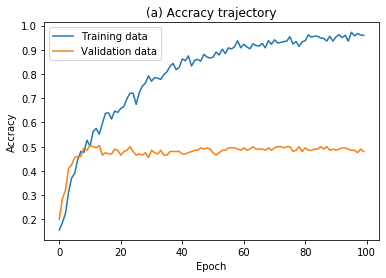

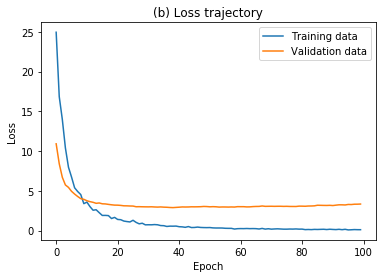

In [7]:
class Machine(aiprt_Machine_Generator):
    def __init__(self):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        _, X, _, y = model_selection.train_test_split(x_train, y_train, test_size=0.02)
        X = X.astype(float)

        # gen_param_dict = {'rotation_range': 10}

        super().__init__(X, y, nb_classes=10)


def main():
    m = Machine()
    m.run()


if __name__ == '__main__':
    main()